# Reading GUPPI raw and injecting a narrow band signal

In [43]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

In [45]:
start_chan = 0
input_file_stem = '/home/eakshay/setigen/data/guppi_with_chanbw_1mhz'

raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)



In [46]:
raw_params

{'num_bits': 8,
 'chan_bw': 1000000.0,
 'ascending': True,
 'num_pols': 1,
 'block_size': 134217728,
 'obs_length': 2.097152,
 'tbin': 1e-06,
 'num_antennas': 1,
 'num_chans': 64,
 'center_freq': 581500000.0,
 'fch1': 550000000.0}

In [47]:
num_branches=1024
sample_rate=raw_params['chan_bw']*num_branches 
num_taps=8



In [48]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

In [49]:
 filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              #filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=64)

In [50]:
#print(antenna.sample_rate)
print('num branches',rvb.num_branches)
print('sample rate in MHz',rvb.sample_rate/1e6)
print('chan bw in MHz',rvb.chan_bw/1e6)
print('tbin',rvb.tbin)
print('fch1',rvb.fch1/1e6)
print(len(rvb.digitizer))

num branches 1024
sample rate in MHz 1024.0
chan bw in MHz 1.0
tbin 1e-06
fch1 550.0
1


In [51]:
from setigen.voltage import raw_utils
print(raw_utils.get_blocks_per_file(input_file_stem))
print(raw_utils.get_total_blocks(input_file_stem))

2
2


In [52]:
#stream.get_total_noise_std() * leakage_factor * signal_level
antenna.x.get_total_noise_std()

array(0.)

In [53]:
fftlength = 1024

signal_level = stg.voltage.get_level(snr=15,
                            raw_voltage_backend=rvb,
                            fftlength=fftlength,
#                             obs_length=4.652881237333333,
#                             length_mode='obs_length'
                            num_blocks=2,
                            length_mode='num_blocks'
                                    )

print('signal level', signal_level)
   


signal level 0.0011244578495109637


In [54]:
f_start=600e6

leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)

# print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')

# level = 1 * leakage_factor * signal_level
# print('\n level:', level)

# antenna.x.add_constant_signal(f_start=f_start, 
#                               drift_rate=0     ,                          #-1*u.Hz/u.s, 
#                               level=level)


####################################################################################################################

for f_start in np.linspace(599.5e6, 600.5e6, 6):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')
    
    for stream in antenna.streams:
        # There's actually no noise present, but we set levels assuming a background noise_std of 1
        level = 1 * leakage_factor * signal_level
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=-1*u.Hz/u.s, 
                                   level=level)

599.5000 MHz leakage factor: 1.000
599.7000 MHz leakage factor: 1.069
599.9000 MHz leakage factor: 1.321
600.1000 MHz leakage factor: 1.321
600.3000 MHz leakage factor: 1.069
600.5000 MHz leakage factor: 1.000


digitize : bool, optional
            Whether to quantize input voltages before the PFB

In [55]:
rvb.record(output_file_stem='/home/eakshay/setigen/data/multiple_signal',
           num_blocks=2, 
           length_mode='num_blocks',
           header_dict={'TELESCOPE': 'GBT'},
           digitize=False,
           verbose=False)


Blocks: 100%|█████████████████████████████████████| 2/2 [00:35<00:00, 17.54s/it]


In [56]:
#header info for the new file with signal 

start_chan = 0
ip_file_stem = '/home/eakshay/setigen/data/multiple_signal'

header_info = stg.voltage.get_raw_params(input_file_stem=ip_file_stem,
                                        start_chan=start_chan)


In [57]:
header_info

{'num_bits': 8,
 'chan_bw': 1000000.0,
 'ascending': True,
 'num_pols': 1,
 'block_size': 134217728,
 'obs_length': 2.097152,
 'tbin': 1e-06,
 'num_antennas': 1,
 'num_chans': 64,
 'center_freq': 581500000.0,
 'fch1': 550000000.0}

In [58]:
raw_params

{'num_bits': 8,
 'chan_bw': 1000000.0,
 'ascending': True,
 'num_pols': 1,
 'block_size': 134217728,
 'obs_length': 2.097152,
 'tbin': 1e-06,
 'num_antennas': 1,
 'num_chans': 64,
 'center_freq': 581500000.0,
 'fch1': 550000000.0}

In [59]:
!rawspec -f 1024 -t 4 -d . /home/eakshay/setigen/data/multiple_signal


working stem: /home/eakshay/setigen/data/multiple_signal
opening file: /home/eakshay/setigen/data/multiple_signal.0000.raw
got error cudaErrorMemoryAllocation at rawspec_gpu.cu:684
rawspec initialization failed
output product 0: 0 spectra


In [60]:
!mv multiple* data

mv: cannot stat 'multiple*': No such file or directory


In [61]:
# from blimpy import Waterfall
# fb = Waterfall('/path/to/filterbank.fil')
# #fb = Waterfall('/path/to/filterbank.h5') #works the same way
# fb.info()
# data = fb.data

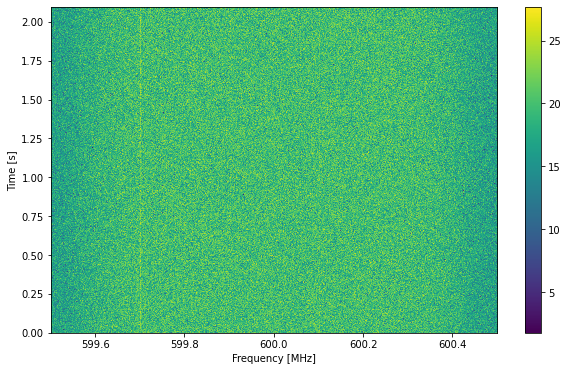

In [62]:
%matplotlib inline 
wf = bl.Waterfall('/home/eakshay/setigen/data/multiple_signal.rawspec.0000.fil',
                  f_start=599.50,
                  f_stop=600.50)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

# wf.info()
# data=wf.data()


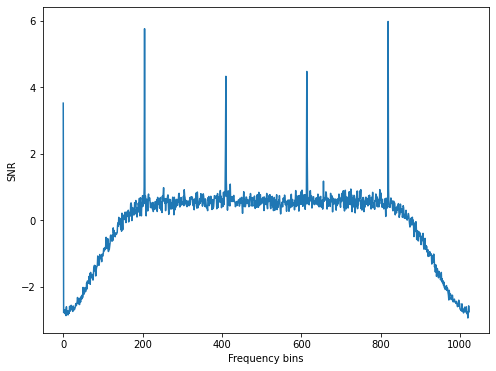

In [63]:
frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()